# Notebook Overview  
**Goal:** MB-pol simulation of a single Na⁺ ion (MB-nrg) solvated in 256 MB-pol water molecules.  
**Workflow:**  
1. Prepare all input files (`mbx.json`, `mbpol.param`, `start.lmp`, `sub.sh`).  
2. Run the production job on your HPC cluster.  
3. Post-process the trajectory with a lightweight *rerun* job.  
4. Visualize radial-distribution functions (RDFs) and mean-square displacements (MSDs).  

> **Data note:** An initial topology file named **`data.system`** containing *256 waters + 1 Na⁺* is already in this directory. 

**Challenge 1**: Go back to Tutorial 1 and modify the input files so it outputs exactly 256 waters and a single Na⁺ ion, then regenerate `data.system` with those settings.


### Preparing input files   
The next few cells create or copy each file into the working directory.


### Create `mbx.json`

Writes a minimal `mbx.json` using Python:

* Builds a `dict` called **`mbx_config`** with the fields described above.  
* For a MBX+LAMMPS simulation, the `box` dimentions will be read by LAMMPS not from `mbx.json`.

Run this cell once; rerun only if you change the dictionary.

In [1]:
import json

mbx_config = {
    "Note": "json file for MB-nrg Na+ in MB-pol water",
    "MBX": {
       "twobody_cutoff"   : 9.0,
       "threebody_cutoff" : 7.0, 
       "max_n_eval_1b"    : 500,
       "max_n_eval_2b"    : 500,
       "max_n_eval_3b"    : 500,
       "dipole_tolerance" : 1E-8,
       "dipole_max_it"    : 100,
       "dipole_method"     : "cg",
       "alpha_ewald_elec" : 0.60,
       "grid_density_elec" : 2.5,
       "spline_order_elec" : 6,
       "alpha_ewald_disp" : 0.60,
       "grid_density_disp" : 2.5,
       "spline_order_disp" : 6,
       "ttm_pairs" : [],
       "ignore_2b_poly" : [],
       "ignore_3b_poly" : []
    }
}

# threebody_cutoff is different: 7.0 instead of 4.5 (why?)
# all the rest - the same

with open('mbx.json', 'w') as f:
    json.dump(mbx_config, f, indent=4)

**Comments**

https://pubs.aip.org/aip/jcp/article/159/5/054802/2904909 - the main paper on the MBX development

E.g. it has a list of supported monomer names, guidelines for choosing params


Basically for all the MB-nrg models involved (in Na+ case, there is a h2o-h2o-h2o 3body model, a na+-h2o-h2o model), each MB-nrg may has a different outer cutoff (as part of the model, and would be found in each model development paper), and the “threebody_cutoff” (not part of the model, but a technical parameter for the MBX software) should use the largest value among all outer cutoffs. large values can be used and will give exactly the same energy value, but will be more costly

It would be nice to automatically determine Rcut and be able to override by json. However that will involve some nontrivial restructuring of the entire code, which hopefully can be done in the future, but now it is like this.

Someone need to develop all combinations of the MB-nrg models upto the nB order that you decide to truncate. Determining the cutoff is the work model developers need to do. If some energy contributions is missing (or hasn’t been developed) you can still run simulation but that energy term will be missing. This is sometimes intentional if we want to study the “3-body effect” for some system for example (https://pubs.acs.org/doi/10.1021/acs.jpcb.5c02697). But yes, users do need to be aware of what energy term they are using and how they want to use it. 

Many of the params are discussed in the same MBX paper/supporting information as i sent above. we generally do not adjust other parameters too much; the only thing we change is we usually have a json template for periodic boundary systems, another template for finite size systems. the difference is in finite size systems the box is an empty array and two of the PME grid parameters are set to zero. these examples can be found in MBX github repo under examples/

### Create `mbpol.param`  
Creates the `mbpol.param` file, which isolates all MB-pol–specific pair styles and cut-offs.


In [2]:
mbpol_param_script = r"""
# MB-pol parameters for Na+/water system

# Defining the Force Field
pair_style      mbx  9.0       # distance cut-off 9.0
pair_coeff      * * 0.0 0.0   # providing dummy number for the pair_coeff
pair_modify     tail yes       # long range correction - yes

# Calculating MB-nrg decomposition
compute         mbx all pair mbx

# Command formula for `fix mbx` for a two-component system
fix             MBX all mbx 2 na+ 1 1 1 ${Na} h2o 2 3 3 ${O} ${H} ${H} json mbx.json
"""

with open('mbpol.param', 'w') as f:
    f.write(mbpol_param_script)

### Generate `start.lmp`  
Creates `start.lmp` with sensible defaults (0.5 fs timestep, 300 K, 1 atm, etc.).  
`read_data data.system` pulls in the pre-built topology that already contains 256 waters and one Na⁺ ion.


In [3]:
start_lmp_script = r"""
# MB-pol ion water simulation

# Define the required variables
variable        temp        equal  298.0
variable        dt          equal  0.5
variable        pressure    equal  1
variable        thermo_freq equal  100
variable        dump_freq   equal  100
variable        nsteps      equal  200000
variable        print_freq  equal  100
variable        seed        equal  134678

timer           timeout 23:50:00 every 1000

# Basic setup
units           real
atom_style      full
boundary        p p p
processors      * * * map xyz

# Read initial configuration
read_data       data.system

# Define atom types and groups
variable        Na equal 1
variable        O  equal 2
variable        H  equal 3
group           na type 1
group           water type 2 3

# MB-pol parameter file
include         mbpol.param

# Neighbor list settings
neighbor        2.0 bin
neigh_modify    every 1 delay 10 check yes

# Timestep
timestep        ${dt}

# Thermodynamics output
thermo_style    custom step time temp etotal pe press vol density lx
thermo          ${thermo_freq}
thermo_modify   flush yes

# Set initial velocities
velocity        all create ${temp} ${seed} rot yes dist gaussian

# Print properties to files
fix             mbx_print all print ${print_freq} "$(time) $(c_mbx[1]) $(c_mbx[2]) $(c_mbx[3]) $(c_mbx[4]) $(c_mbx[6]) $(c_mbx[6]) $(c_mbx[7]) $(c_mbx[8])" file mbx_thermo.out screen no title "# time e1bpip e2bpip e3bpip e4bpip edisp ebuck eele etot"
fix             thermo_print all print ${print_freq} "$(step) $(time) $(temp) $(etotal) $(ke) $(pe) $(enthalpy) $(density) $(lx) $(ly) $(lz) $(vol) $(pxx) $(pyy) $(pzz) $(press)" file thermo.out screen no title "# step time temp etotal ke pe enthalpy density lx ly lz vol pxx pyy pzz press"

# NPT simulation integrator
fix             NPT all npt temp ${temp} ${temp} $(100.0*dt) iso ${pressure} ${pressure} $(1000.0*dt)

# Dump trajectory
dump            DUMP all custom ${dump_freq} traj_npt.lammpstrj id type xu yu zu
dump_modify     DUMP sort id

# Write restart files
restart         1000 restart.1 restart.2

# Run the simulation
run             ${nsteps}

# Write final configuration
write_data      final_data.system nocoeff
"""

with open('start.lmp', 'w') as f:
    f.write(start_lmp_script)

### Generate `sub.sh`  


In [4]:
sub_sh_script = r"""#!/bin/bash

#SBATCH --job-name="ion-water"
#SBATCH --partition=shared
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=32GB
#SBATCH --reservation=QDMS-CPU
#SBATCH -A csd973
#SBATCH --export=ALL
#SBATCH -t 24:00:00

module purge
module load shared slurm/expanse/23.02.7 sdsc/1.0 DefaultModules slurm/expanse/23.02.7 cpu/0.17.3b intel/19.1.3.304/6pv46so intel-tbb/2020.3/lfesfxm intel-mpi/2019.10.317/ezrfjne fftw/3.3.10/tqkvj37

lammps=/expanse/projects/qstore/csd973/bin/lmp_mpi_mbx

export OMP_NUM_THREADS=16

$lammps -in start.lmp
"""

with open('sub.sh', 'w') as f:
    f.write(sub_sh_script)

### How to Submit / Monitor  
Provides quick-start commands:  

* `!sbatch sub.sh` – queues the job.  
* `!squeue --me` – checks its status.  

In [6]:
!sbatch sub.sh

Submitted batch job 41156643


In [7]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          41156643    shared ion-wate ypolyach  R       0:06      1 exp-2-45


### Generate `rerun_analysis.lmp`  
Writes a new LAMMPS script that:  

* `read_data data.system` – loads the original topology.  
* `rerun trajectory.lammpstrj` – feeds in frames from the production run.  
* Defines `compute rdf` and `compute msd` for water and Na⁺.  

Outputs plain-text files (`rdf.out`, `water_msd.out`, `na_msd.out`) for plotting.


In [ ]:
rerun_lmp_script = r"""
# MB-pol Ion-Water simulation (rerun for analysis)

# Setup
units           real
atom_style      full
boundary        p p p
read_data       data.system

# Definitions
variable        dt equal 0.5
variable        Na equal 1
variable        O  equal 2
variable        H  equal 3
group           na type 1
group           water type 2 3
timestep        ${dt}

# MB-pol parameter file
include mbpol.param

thermo          1
thermo_modify   flush yes

# Print properties to files
fix             mbx_print all print 1 "$(time) $(c_mbx[1]) $(c_mbx[2]) $(c_mbx[3]) $(c_mbx[4]) $(c_mbx[6]) $(c_mbx[6]) $(c_mbx[7]) $(c_mbx[8])" file mbx_thermo.out screen no title "# time e1bpip e2bpip e3bpip e4bpip edisp ebuck eele etot"
fix             thermo_print all print 1 "$(step) $(time) $(temp) $(etotal) $(ke) $(pe) $(enthalpy) $(density) $(lx) $(ly) $(lz) $(vol) $(pxx) $(pyy) $(pzz) $(press)" file thermo.out screen no title "# step time temp etotal ke pe enthalpy density lx ly lz vol pxx pyy pzz press"

# RDF calculation for O-O and Na-O pairs
compute         myRDF all rdf 100 ${O} ${O} ${Na} ${O}
fix             rdfout all ave/time 1 1 100 c_myRDF[*] file rdf.out mode vector ave running

# MSD calculation for water
compute         WaterMSD water msd com yes average yes
fix             water_msd_print all print 1 "$(time) $(c_WaterMSD[4])" file water_msd.out screen no title "# time MSD_water"

# Rerun the trajectory
rerun           /expanse/projects/qstore/csd973/long_trajs/ionwater_traj/traj_npt.lammpstrj dump x y z
"""

with open('rerun_analysis.lmp', 'w') as f:
    f.write(rerun_lmp_script)

### Run Analysis Job  


In [2]:
sub_sh_script = r"""#!/bin/bash

#SBATCH --job-name="rerun"
#SBATCH --output="rerun.out"
#SBATCH --partition=debug
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=32GB
#SBATCH -A csd973
#SBATCH --export=ALL
#SBATCH -t 00:30:00

module purge
module load shared slurm/expanse/23.02.7 sdsc/1.0 DefaultModules slurm/expanse/23.02.7 cpu/0.17.3b intel/19.1.3.304/6pv46so intel-tbb/2020.3/lfesfxm intel-mpi/2019.10.317/ezrfjne fftw/3.3.10/tqkvj37

lammps=/expanse/projects/qstore/csd973/bin/lmp_mpi_mbx

export OMP_NUM_THREADS=16

$lammps -in rerun_analysis.lmp -log rerun.log
"""

with open('resub.sh', 'w') as f:
    f.write(sub_sh_script)

In [3]:
!sbatch resub.sh

Submitted batch job 41045765


In [4]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          41045765     debug    rerun   s7saha  R       0:01      1 exp-9-55
          41045762     debug    rerun   s7saha  R       0:22      1 exp-9-55
          41041174    shared ion-wate   s7saha  R    5:42:14      1 exp-1-27


In [7]:
!tail rerun.out

[MBX] ELE_PME_D           :        8.5733        8.5733        8.5733      5409    15.48%
[MBX] ELE_PME_E           :       0.91441       0.91441       0.91441       427     1.65%
[MBX] DISP_PME_SETUP      :       0.88175       0.88175       0.88175       427     1.59%
[MBX] DISP_PME_E          :        1.4096        1.4096        1.4096       427     2.55%
[MBX] ELE_COMM_REVFOR     :      0.090833      0.090833      0.090833      5409     0.16%
[MBX] ELE_COMM_REVSET     :     0.0084485     0.0084485     0.0084485       427     0.02%
[MBX] ELE_COMM_REV        :    0.00099295    0.00099295    0.00099295      4982     0.00%
[MBX] ELE_COMM_FORSET     :      0.036591      0.036591      0.036591       427     0.07%
[MBX] ELE_COMM_FOR        :      0.028009      0.028009      0.028009      4982     0.05%
Total wall time: 0:00:55


### Plot RDFs + MSDs

Python code reads the output files, constructs distance/time arrays, and uses `matplotlib` to draw:

- **g<sub>NaO</sub>(r)** — Na⁺–oxygen radial-distribution function  
- **g<sub>OO</sub>(r)** — water oxygen–oxygen RDF  
- **MSD(t)** — separate curves for water


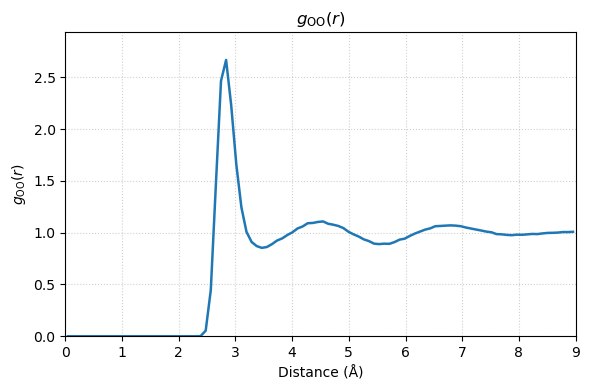

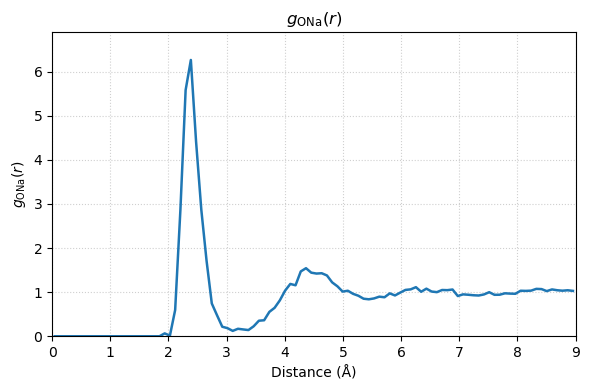

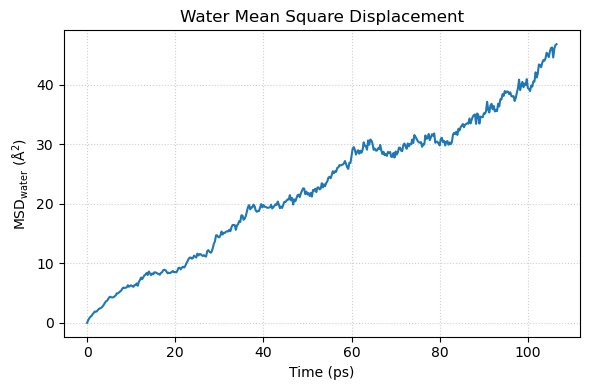

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- File names ---
rdf_file       = "rdf.out"
water_msd_file = "water_msd.out"
# --------------------

# --- Read RDF file and find last block header ---
with open(rdf_file, "r") as fh:
    lines = fh.readlines()

blocks = []
for i, ln in enumerate(lines):
    if ln.startswith("#"):
        continue
    toks = ln.split()
    if len(toks) == 2 and toks[0].isdigit() and toks[1].isdigit():
        ts, nbins = map(int, toks)
        blocks.append((i+1, nbins, ts))

# pick the last block
start, nbins, last_ts = blocks[-1]

# load exactly nbins data rows
rdf_block = [
    [float(x) for x in ln.split()]
    for ln in lines[start : start + nbins]
    if ln.strip() and not ln.startswith("#")
]
data = np.array(rdf_block)

# extract columns: 
#   column 1 = r, 
#   column 2 = c_myRDF[2] = g_OO, 
#   column 4 = c_myRDF[3] = g_ONa
r_vals = data[:, 1]
g_OO   = data[:, 2]
g_ONa  = data[:, 4]

# --- Plot g_OO(r) ---
plt.figure(figsize=(6,4))
plt.plot(r_vals, g_OO, lw=1.8)
plt.xlabel("Distance (Å)")
plt.ylabel(r"$g_{\mathrm{OO}}(r)$")
plt.title(f"$g_{{\mathrm{{OO}}}}(r)$")
plt.xlim(0, 9)
plt.ylim(0, g_OO.max() * 1.1)
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

# --- Plot g_ONa(r) ---
plt.figure(figsize=(6,4))
plt.plot(r_vals, g_ONa, lw=1.8)
plt.xlabel("Distance (Å)")
plt.ylabel(r"$g_{\mathrm{ONa}}(r)$")
plt.title(f"$g_{{\mathrm{{ONa}}}}(r)$")
plt.xlim(0, 9)
plt.ylim(0, g_ONa.max() * 1.1)
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

# --- Load MSD data ---
df_water = pd.read_csv(
    water_msd_file,
    sep=r'\s+',
    comment="#",
    header=None,
    names=["time_fs", "msd_water"]
)

# convert to ps and arrays
t_w = df_water["time_fs"].to_numpy() / 1e3  # fs → ps
m_w = df_water["msd_water"].to_numpy()

# --- Plot Water MSD ---
plt.figure(figsize=(6,4))
plt.plot(t_w, m_w, lw=1.5)
plt.xlabel("Time (ps)")
plt.ylabel(r"MSD$_\mathrm{water}$ (Å$^{2}$)")
plt.title("Water Mean Square Displacement")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

# --- Show all figures ---
plt.show()


### MB-nrg energy decomposition & basic thermodynamic checks  

This section does two things:

1. **Many-body PIP energies** – plots the 1-, 2- and 3-body polynomial interaction energies (`E1b_PIP`, `E2b_PIP`, `E3b_PIP`) written by MBX.  
2. **Time-series monitors** – shows how temperature, potential energy, density and pressure evolve, so you can confirm the system has reached steady state.

Replace the file paths in the first code cell (`mbnrg_file`, `thermo_file`) with the names in your run directory and execute once.  
*All time axes are converted from femtoseconds to picoseconds for readability.*


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ─── file names to edit ───────────────────────────────────────────────
mbnrg_file  = "./mbx_thermo.out"
thermo_file = "./thermo.out"
# ──────────────────────────────────────────────────────────────────────

# --------------------  MB-nrg PIP energies  ---------------------------
def plot_MBnrg(file_path):
    df = pd.read_csv(file_path, sep=r'\s+', comment='#', header=None)
    df = df.iloc[:, :4]
    df.columns = ['time', 'e1b', 'e2b', 'e3b']

    # convert to NumPy arrays
    t_ps = (df['time'] / 1e3).to_numpy()
    e1   = df['e1b'].to_numpy()
    e2   = df['e2b'].to_numpy()
    e3   = df['e3b'].to_numpy()

    plt.figure()
    plt.plot(t_ps, e1, label='E1b_PIP')
    plt.plot(t_ps, e2, label='E2b_PIP')
    plt.plot(t_ps, e3, label='E3b_PIP')
    plt.xlabel('Time (ps)')
    plt.ylabel('Energy (kcal/mol)')
    plt.title('MB-nrg PIP energy components')
    plt.xlim(0, t_ps[-1])
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_MBnrg(mbnrg_file)


# --------------------  Thermodynamic series  --------------------------
required_cols = ['time', 'temp', 'pe', 'density', 'press']

def load_data(path):
    df = pd.read_csv(
        path,
        sep=r'\s+',
        comment='#',
        header=None,
        usecols=[1, 2, 5, 7, 15]
    )
    df.columns = required_cols
    df['time'] /= 1e3
    return df

def plot_time_vs_column(df, col, y_label, y_unit):
    # convert both axes to NumPy
    t = df['time'].to_numpy()
    y = df[col].to_numpy()

    plt.figure()
    plt.plot(t, y)
    plt.xlabel('Time (ps)')
    plt.ylabel(f'{y_label} ({y_unit})')
    plt.title(f'{y_label} vs Time')
    plt.xlim(0, t[-1])
    plt.tight_layout()
    plt.show()

thermo_df = load_data(thermo_file)

plot_time_vs_column(thermo_df, 'temp',    'Temperature',      'K')
plot_time_vs_column(thermo_df, 'pe',      'Potential Energy', 'kcal/mol')
plot_time_vs_column(thermo_df, 'density', 'Density',          'g cm$^{-3}$')
plot_time_vs_column(thermo_df, 'press',   'Pressure',         'atm')